## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [1]:
idxs = range(65)
idxs

range(0, 65)

In [2]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [3]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [4]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [6]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [7]:
import segmentation_models_pytorch as smp

In [8]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [9]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp015'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 7 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [12]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [13]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [14]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [15]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    # idxs = range(start, end)
    idxs = [26,28,30,32,34,36,38]

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [16]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [17]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [19]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [20]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [21]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [22]:
train_dataset[0][0].shape

torch.Size([7, 224, 224])

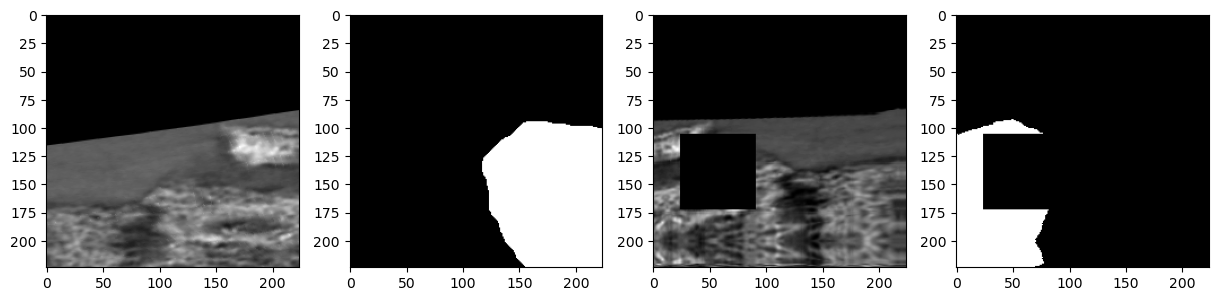

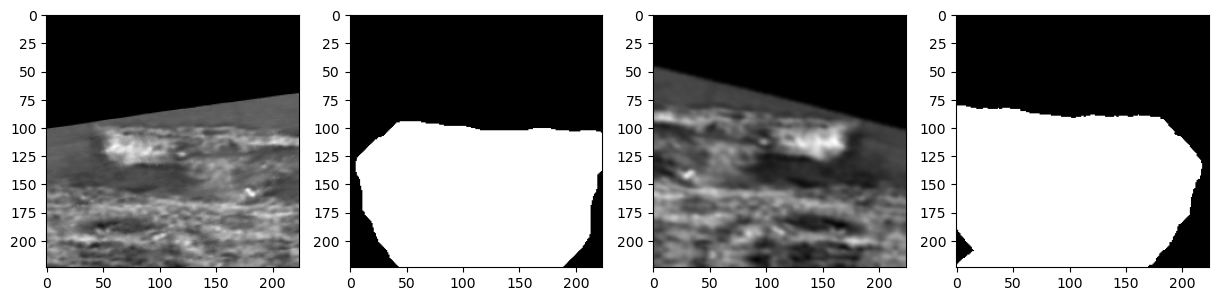

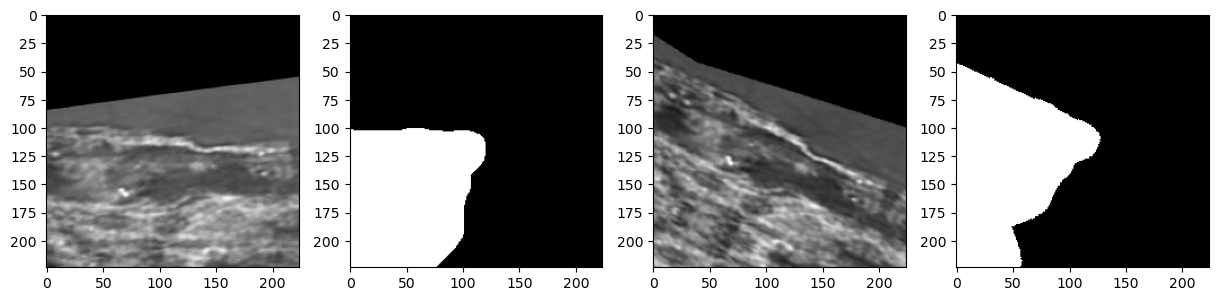

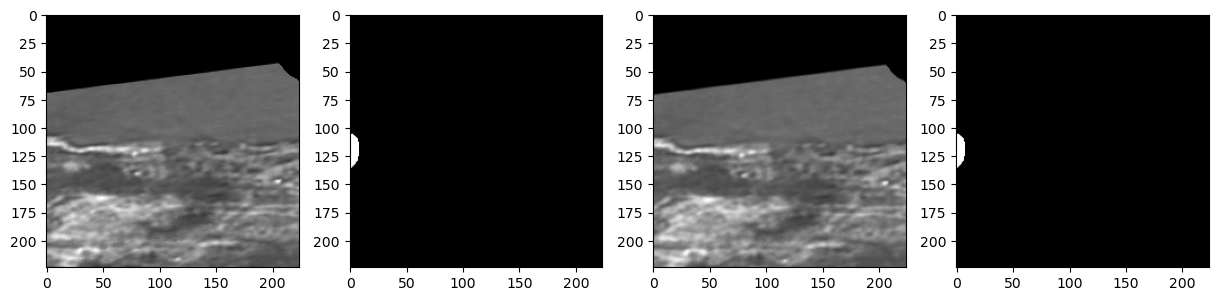

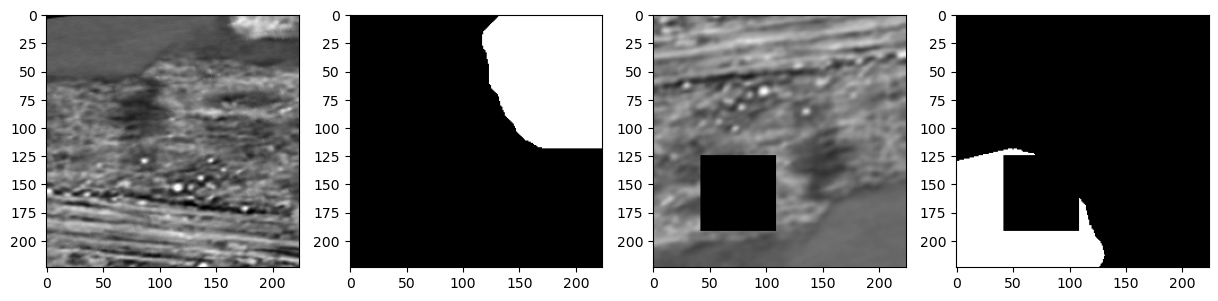

In [23]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [24]:
del plot_dataset
gc.collect()

48130

## model

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [26]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [27]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [28]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:
fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14222139162238445
th: 0.15, fbeta: 0.16613720080766245
th: 0.2, fbeta: 0.21740118767623481
th: 0.25, fbeta: 0.2381849938416637
th: 0.3, fbeta: 0.26287438786768513
th: 0.35, fbeta: 0.2850042263580029
th: 0.4, fbeta: 0.29043460179928327
th: 0.45, fbeta: 0.24504809348537818


best_th: 0.4, fbeta: 0.29043460179928327
Epoch 1 - avg_train_loss: 0.4191  avg_val_loss: 0.3937  time: 166s
Epoch 1 - avgScore: 0.2904
Epoch 1 - Save Best Score: 0.2904 Model
Epoch 1 - Save Best Loss: 0.3937 Model


th: 0.5, fbeta: 0.12780807082597712


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.15015624156398288
th: 0.15, fbeta: 0.21962362394203308
th: 0.2, fbeta: 0.2593872077925769
th: 0.25, fbeta: 0.31423238966879374
th: 0.3, fbeta: 0.34996469673307706
th: 0.35, fbeta: 0.3355426742423812
th: 0.4, fbeta: 0.24878435371889226
th: 0.45, fbeta: 0.11887042926583022


best_th: 0.3, fbeta: 0.34996469673307706
Epoch 2 - avg_train_loss: 0.3269  avg_val_loss: 0.3468  time: 165s
Epoch 2 - avgScore: 0.3500
Epoch 2 - Save Best Score: 0.3500 Model
Epoch 2 - Save Best Loss: 0.3468 Model


th: 0.5, fbeta: 0.029619311502535522


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.3407334548456133
th: 0.15, fbeta: 0.38542437871028906
th: 0.2, fbeta: 0.3704109519538432
th: 0.25, fbeta: 0.28743669806052147
th: 0.3, fbeta: 0.20615807288488888
th: 0.35, fbeta: 0.14389682956598013
th: 0.4, fbeta: 0.0977120866981562
th: 0.45, fbeta: 0.0621331768503165


best_th: 0.15, fbeta: 0.38542437871028906
Epoch 3 - avg_train_loss: 0.2392  avg_val_loss: 0.3289  time: 165s
Epoch 3 - avgScore: 0.3854
Epoch 3 - Save Best Score: 0.3854 Model
Epoch 3 - Save Best Loss: 0.3289 Model


th: 0.5, fbeta: 0.03792294691134401


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3890478514837942
th: 0.15, fbeta: 0.2980348690514114
th: 0.2, fbeta: 0.19197151995113773
th: 0.25, fbeta: 0.11853191378689444
th: 0.3, fbeta: 0.07684448011011513
th: 0.35, fbeta: 0.04860031652369673
th: 0.4, fbeta: 0.030388396681786035
th: 0.45, fbeta: 0.018456690910671127


best_th: 0.1, fbeta: 0.3890478514837942
Epoch 4 - avg_train_loss: 0.1999  avg_val_loss: 0.3746  time: 164s
Epoch 4 - avgScore: 0.3890
Epoch 4 - Save Best Score: 0.3890 Model
Epoch 4 - Save Best Loss: 0.3746 Model


th: 0.5, fbeta: 0.011671378129573192


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4161962290610269
th: 0.15, fbeta: 0.40821676605790996
th: 0.2, fbeta: 0.3813621867781325
th: 0.25, fbeta: 0.34409003228578117
th: 0.3, fbeta: 0.30193990847362256
th: 0.35, fbeta: 0.25900740882090395
th: 0.4, fbeta: 0.21833867458215445
th: 0.45, fbeta: 0.18003779676206919


best_th: 0.1, fbeta: 0.4161962290610269
Epoch 5 - avg_train_loss: 0.1865  avg_val_loss: 0.4115  time: 165s
Epoch 5 - avgScore: 0.4162
Epoch 5 - Save Best Score: 0.4162 Model
Epoch 5 - Save Best Loss: 0.4115 Model


th: 0.5, fbeta: 0.14313818930270567


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4179090826437965
th: 0.15, fbeta: 0.4017160210028
th: 0.2, fbeta: 0.33810219268847247
th: 0.25, fbeta: 0.27390330629141457
th: 0.3, fbeta: 0.22040555740740958
th: 0.35, fbeta: 0.17785251103718927
th: 0.4, fbeta: 0.1442501787894649
th: 0.45, fbeta: 0.11890072036096275


best_th: 0.1, fbeta: 0.4179090826437965
Epoch 6 - avg_train_loss: 0.1758  avg_val_loss: 0.3868  time: 167s
Epoch 6 - avgScore: 0.4179
Epoch 6 - Save Best Score: 0.4179 Model
Epoch 6 - Save Best Loss: 0.3868 Model


th: 0.5, fbeta: 0.09752586415989552


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4000665800306615
th: 0.15, fbeta: 0.37772529813133093
th: 0.2, fbeta: 0.3474992360868133
th: 0.25, fbeta: 0.31366989450054206
th: 0.3, fbeta: 0.2755998385028799
th: 0.35, fbeta: 0.23496184873236886
th: 0.4, fbeta: 0.19738276259863957
th: 0.45, fbeta: 0.1633504677453358


best_th: 0.1, fbeta: 0.4000665800306615
Epoch 7 - avg_train_loss: 0.1624  avg_val_loss: 0.4052  time: 167s
Epoch 7 - avgScore: 0.4001


th: 0.5, fbeta: 0.13204981966522575


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36300426512542794
th: 0.15, fbeta: 0.3675824036969883
th: 0.2, fbeta: 0.36724639333391373
th: 0.25, fbeta: 0.35970284816733744
th: 0.3, fbeta: 0.34485177295074587
th: 0.35, fbeta: 0.3257237823512236
th: 0.4, fbeta: 0.3019689798356429
th: 0.45, fbeta: 0.27909656134305094


best_th: 0.15, fbeta: 0.3675824036969883
Epoch 8 - avg_train_loss: 0.1526  avg_val_loss: 0.4137  time: 167s
Epoch 8 - avgScore: 0.3676


th: 0.5, fbeta: 0.2570541662232151


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37149065275946047
th: 0.15, fbeta: 0.3505705485018567
th: 0.2, fbeta: 0.3224607304954618
th: 0.25, fbeta: 0.2888723101875318
th: 0.3, fbeta: 0.25121359430399715
th: 0.35, fbeta: 0.21234183974090098
th: 0.4, fbeta: 0.17480321121101713
th: 0.45, fbeta: 0.14187156708818946


best_th: 0.1, fbeta: 0.37149065275946047
Epoch 9 - avg_train_loss: 0.1409  avg_val_loss: 0.5292  time: 166s
Epoch 9 - avgScore: 0.3715


th: 0.5, fbeta: 0.11489471268986527


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3349234940088676
th: 0.15, fbeta: 0.3084408310360474
th: 0.2, fbeta: 0.2805642689985956
th: 0.25, fbeta: 0.25168253103283456
th: 0.3, fbeta: 0.22103155202598168
th: 0.35, fbeta: 0.1901467349563907
th: 0.4, fbeta: 0.15976528107572
th: 0.45, fbeta: 0.13271687011532948


best_th: 0.1, fbeta: 0.3349234940088676
Epoch 10 - avg_train_loss: 0.1327  avg_val_loss: 0.5912  time: 167s
Epoch 10 - avgScore: 0.3349


th: 0.5, fbeta: 0.1092773895638472


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2665647231068605
th: 0.15, fbeta: 0.2225385426360731
th: 0.2, fbeta: 0.1837928737556602
th: 0.25, fbeta: 0.14990878567118698
th: 0.3, fbeta: 0.12345095242216708
th: 0.35, fbeta: 0.10132020718528692
th: 0.4, fbeta: 0.08156583498527578
th: 0.45, fbeta: 0.06629308017357692


best_th: 0.1, fbeta: 0.2665647231068605
Epoch 11 - avg_train_loss: 0.1223  avg_val_loss: 0.6588  time: 166s
Epoch 11 - avgScore: 0.2666


th: 0.5, fbeta: 0.05383126925372234


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3301406129530281
th: 0.15, fbeta: 0.2998188752121269
th: 0.2, fbeta: 0.2670680080415763
th: 0.25, fbeta: 0.23528810288629531
th: 0.3, fbeta: 0.20440257321737465
th: 0.35, fbeta: 0.17439103580350865
th: 0.4, fbeta: 0.14993029314094025
th: 0.45, fbeta: 0.1283502315071908


best_th: 0.1, fbeta: 0.3301406129530281
Epoch 12 - avg_train_loss: 0.1136  avg_val_loss: 0.5911  time: 166s
Epoch 12 - avgScore: 0.3301


th: 0.5, fbeta: 0.10864882353177531


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34756479761054154
th: 0.15, fbeta: 0.338813672218289
th: 0.2, fbeta: 0.32124687042294797
th: 0.25, fbeta: 0.299829701918827
th: 0.3, fbeta: 0.2766298663563634
th: 0.35, fbeta: 0.2511030527950806
th: 0.4, fbeta: 0.22384294031809557
th: 0.45, fbeta: 0.1968087167950421


best_th: 0.1, fbeta: 0.34756479761054154
Epoch 13 - avg_train_loss: 0.1057  avg_val_loss: 0.5736  time: 166s
Epoch 13 - avgScore: 0.3476


th: 0.5, fbeta: 0.1719668408772703


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32725054304379775
th: 0.15, fbeta: 0.31472958908862636
th: 0.2, fbeta: 0.2963203620696119
th: 0.25, fbeta: 0.2756067345904446
th: 0.3, fbeta: 0.25438718512081465
th: 0.35, fbeta: 0.23321926649005756
th: 0.4, fbeta: 0.2099146225106077
th: 0.45, fbeta: 0.1865598524057119


best_th: 0.1, fbeta: 0.32725054304379775
Epoch 14 - avg_train_loss: 0.1001  avg_val_loss: 0.6093  time: 166s
Epoch 14 - avgScore: 0.3273


th: 0.5, fbeta: 0.16480604198275806


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35486646620787426
th: 0.15, fbeta: 0.34691649064514346
th: 0.2, fbeta: 0.33330580332759635
th: 0.25, fbeta: 0.3158689786417078
th: 0.3, fbeta: 0.29792529275256907
th: 0.35, fbeta: 0.2783114234566332
th: 0.4, fbeta: 0.25631555637298975
th: 0.45, fbeta: 0.23291220249300568


best_th: 0.1, fbeta: 0.35486646620787426
Epoch 15 - avg_train_loss: 0.0918  avg_val_loss: 0.6431  time: 167s
Epoch 15 - avgScore: 0.3549


th: 0.5, fbeta: 0.20875493517059926


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3346273333406902
th: 0.15, fbeta: 0.32232544793026674
th: 0.2, fbeta: 0.30496774218137074
th: 0.25, fbeta: 0.2827872915848518
th: 0.3, fbeta: 0.2579303874371288
th: 0.35, fbeta: 0.23144550127207877
th: 0.4, fbeta: 0.20222379878875216
th: 0.45, fbeta: 0.17413422546481028


best_th: 0.1, fbeta: 0.3346273333406902
Epoch 16 - avg_train_loss: 0.0859  avg_val_loss: 0.6450  time: 165s
Epoch 16 - avgScore: 0.3346


th: 0.5, fbeta: 0.14838213625933958


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35295880132934354
th: 0.15, fbeta: 0.3339483147255208
th: 0.2, fbeta: 0.31439255667386035
th: 0.25, fbeta: 0.29135331495909556
th: 0.3, fbeta: 0.2664021141239238
th: 0.35, fbeta: 0.242264435055333
th: 0.4, fbeta: 0.2191486275258625
th: 0.45, fbeta: 0.19517093290365467


best_th: 0.1, fbeta: 0.35295880132934354
Epoch 17 - avg_train_loss: 0.0806  avg_val_loss: 0.6707  time: 167s
Epoch 17 - avgScore: 0.3530


th: 0.5, fbeta: 0.1714757818890023


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29717572459123803
th: 0.15, fbeta: 0.27790200403133736
th: 0.2, fbeta: 0.25700964137772075
th: 0.25, fbeta: 0.2370090201405454
th: 0.3, fbeta: 0.21766789571286907
th: 0.35, fbeta: 0.19960365894044077
th: 0.4, fbeta: 0.18044547254642654
th: 0.45, fbeta: 0.16172980421630243


best_th: 0.1, fbeta: 0.29717572459123803
Epoch 18 - avg_train_loss: 0.0772  avg_val_loss: 0.7618  time: 166s
Epoch 18 - avgScore: 0.2972


th: 0.5, fbeta: 0.14457686145819917


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37242917031173706
th: 0.15, fbeta: 0.3630887856469167
th: 0.2, fbeta: 0.35072898344335146
th: 0.25, fbeta: 0.3364933470119011
th: 0.3, fbeta: 0.3177321037259441
th: 0.35, fbeta: 0.29641661006645137
th: 0.4, fbeta: 0.27207975233377263
th: 0.45, fbeta: 0.24655091208532942


best_th: 0.1, fbeta: 0.37242917031173706
Epoch 19 - avg_train_loss: 0.0709  avg_val_loss: 0.7342  time: 167s
Epoch 19 - avgScore: 0.3724


th: 0.5, fbeta: 0.2217400902115033


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3149191750359035
th: 0.15, fbeta: 0.2852291414797434
th: 0.2, fbeta: 0.2534469240336834
th: 0.25, fbeta: 0.22436523142008694
th: 0.3, fbeta: 0.19961780230333992
th: 0.35, fbeta: 0.17832199833208937
th: 0.4, fbeta: 0.1581907253411602
th: 0.45, fbeta: 0.13809992010140876


best_th: 0.1, fbeta: 0.3149191750359035
Epoch 20 - avg_train_loss: 0.0682  avg_val_loss: 0.8070  time: 166s
Epoch 20 - avgScore: 0.3149


th: 0.5, fbeta: 0.1190136038852544


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33631003705171
th: 0.15, fbeta: 0.3214047036942793
th: 0.2, fbeta: 0.3010198253292734
th: 0.25, fbeta: 0.2768752811394735
th: 0.3, fbeta: 0.25351985774269603
th: 0.35, fbeta: 0.23059724497017633
th: 0.4, fbeta: 0.20719982537701973
th: 0.45, fbeta: 0.1860096966917495


best_th: 0.1, fbeta: 0.33631003705171
Epoch 21 - avg_train_loss: 0.0634  avg_val_loss: 0.7157  time: 168s
Epoch 21 - avgScore: 0.3363


th: 0.5, fbeta: 0.16484526887787165


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32107298093275954
th: 0.15, fbeta: 0.3062248249372539
th: 0.2, fbeta: 0.2874355320039865
th: 0.25, fbeta: 0.26521944634922623
th: 0.3, fbeta: 0.2439100261481931
th: 0.35, fbeta: 0.22544275105873987
th: 0.4, fbeta: 0.20590410625016967
th: 0.45, fbeta: 0.1847267272303237


best_th: 0.1, fbeta: 0.32107298093275954
Epoch 22 - avg_train_loss: 0.0618  avg_val_loss: 0.8189  time: 166s
Epoch 22 - avgScore: 0.3211


th: 0.5, fbeta: 0.1626050299572789


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30084686942737987
th: 0.15, fbeta: 0.2822077383906824
th: 0.2, fbeta: 0.2610773113641079
th: 0.25, fbeta: 0.23658521967544158
th: 0.3, fbeta: 0.21694857145406254
th: 0.35, fbeta: 0.19799368343817716
th: 0.4, fbeta: 0.1788470629412062
th: 0.45, fbeta: 0.15927487528728224


best_th: 0.1, fbeta: 0.30084686942737987
Epoch 23 - avg_train_loss: 0.0596  avg_val_loss: 0.8543  time: 167s
Epoch 23 - avgScore: 0.3008


th: 0.5, fbeta: 0.13713764134329082


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3258371642257537
th: 0.15, fbeta: 0.3118043282681591
th: 0.2, fbeta: 0.29672808691727537
th: 0.25, fbeta: 0.2790630670708356
th: 0.3, fbeta: 0.2595775429063079
th: 0.35, fbeta: 0.23928313221580552
th: 0.4, fbeta: 0.2173918525647193
th: 0.45, fbeta: 0.1951621810550633


best_th: 0.1, fbeta: 0.3258371642257537
Epoch 24 - avg_train_loss: 0.0549  avg_val_loss: 0.8441  time: 166s
Epoch 24 - avgScore: 0.3258


th: 0.5, fbeta: 0.17179929778268235


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3056744373685683
th: 0.15, fbeta: 0.2850458990478293
th: 0.2, fbeta: 0.2646885996198454
th: 0.25, fbeta: 0.24176128802310046
th: 0.3, fbeta: 0.22133512735267308
th: 0.35, fbeta: 0.20289110497943968
th: 0.4, fbeta: 0.1848788377159555
th: 0.45, fbeta: 0.16622643514919413


best_th: 0.1, fbeta: 0.3056744373685683
Epoch 25 - avg_train_loss: 0.0531  avg_val_loss: 0.8435  time: 167s
Epoch 25 - avgScore: 0.3057


th: 0.5, fbeta: 0.14424784005044097


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31949892316294193
th: 0.15, fbeta: 0.30191664124451173
th: 0.2, fbeta: 0.2826236353783575
th: 0.25, fbeta: 0.25774326892491045
th: 0.3, fbeta: 0.23767651462426934
th: 0.35, fbeta: 0.21908582007634206
th: 0.4, fbeta: 0.1992484073861135
th: 0.45, fbeta: 0.1784481272145211


best_th: 0.1, fbeta: 0.31949892316294193
Epoch 26 - avg_train_loss: 0.0523  avg_val_loss: 0.8371  time: 167s
Epoch 26 - avgScore: 0.3195


th: 0.5, fbeta: 0.15396917266687268


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32435700862097105
th: 0.15, fbeta: 0.3078771739923222
th: 0.2, fbeta: 0.2903566197055203
th: 0.25, fbeta: 0.2668255324439569
th: 0.3, fbeta: 0.24709877140419148
th: 0.35, fbeta: 0.22705579946466947
th: 0.4, fbeta: 0.206930046354644
th: 0.45, fbeta: 0.18607527730299261


best_th: 0.1, fbeta: 0.32435700862097105
Epoch 27 - avg_train_loss: 0.0510  avg_val_loss: 0.8602  time: 166s
Epoch 27 - avgScore: 0.3244


th: 0.5, fbeta: 0.16022217192007526


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30849863916663633
th: 0.15, fbeta: 0.28864393354017703
th: 0.2, fbeta: 0.26892398541382273
th: 0.25, fbeta: 0.24490827479407068
th: 0.3, fbeta: 0.22263183970857908
th: 0.35, fbeta: 0.20087466442107774
th: 0.4, fbeta: 0.1796494767075543
th: 0.45, fbeta: 0.15870630582937414


best_th: 0.1, fbeta: 0.30849863916663633
Epoch 28 - avg_train_loss: 0.0497  avg_val_loss: 0.9123  time: 168s
Epoch 28 - avgScore: 0.3085


th: 0.5, fbeta: 0.13742809256494357


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3109720826003043
th: 0.15, fbeta: 0.2940516130034553
th: 0.2, fbeta: 0.2748519014523212
th: 0.25, fbeta: 0.25382523668984536
th: 0.3, fbeta: 0.2321949685404832
th: 0.35, fbeta: 0.2120568080535716
th: 0.4, fbeta: 0.19081731178454536
th: 0.45, fbeta: 0.1689347139532295


best_th: 0.1, fbeta: 0.3109720826003043
Epoch 29 - avg_train_loss: 0.0497  avg_val_loss: 0.8776  time: 167s
Epoch 29 - avgScore: 0.3110


th: 0.5, fbeta: 0.1456623025037725


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31042748574279533
th: 0.15, fbeta: 0.2918870959430151
th: 0.2, fbeta: 0.27206593087703734
th: 0.25, fbeta: 0.2487364876138739
th: 0.3, fbeta: 0.22666068097839479
th: 0.35, fbeta: 0.20504075294782176
th: 0.4, fbeta: 0.1839774197079096
th: 0.45, fbeta: 0.16296828784106202


best_th: 0.1, fbeta: 0.31042748574279533
Epoch 30 - avg_train_loss: 0.0490  avg_val_loss: 0.8827  time: 167s
Epoch 30 - avgScore: 0.3104


th: 0.5, fbeta: 0.1389524650740279


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4179090826437965
th: 0.15, fbeta: 0.4017160210028
th: 0.2, fbeta: 0.33810219268847247
th: 0.25, fbeta: 0.27390330629141457
th: 0.3, fbeta: 0.22040555740740958
th: 0.35, fbeta: 0.17785251103718927
th: 0.4, fbeta: 0.1442501787894649
th: 0.45, fbeta: 0.11890072036096275


best_th: 0.1, fbeta: 0.4179090826437965


th: 0.5, fbeta: 0.09752586415989552


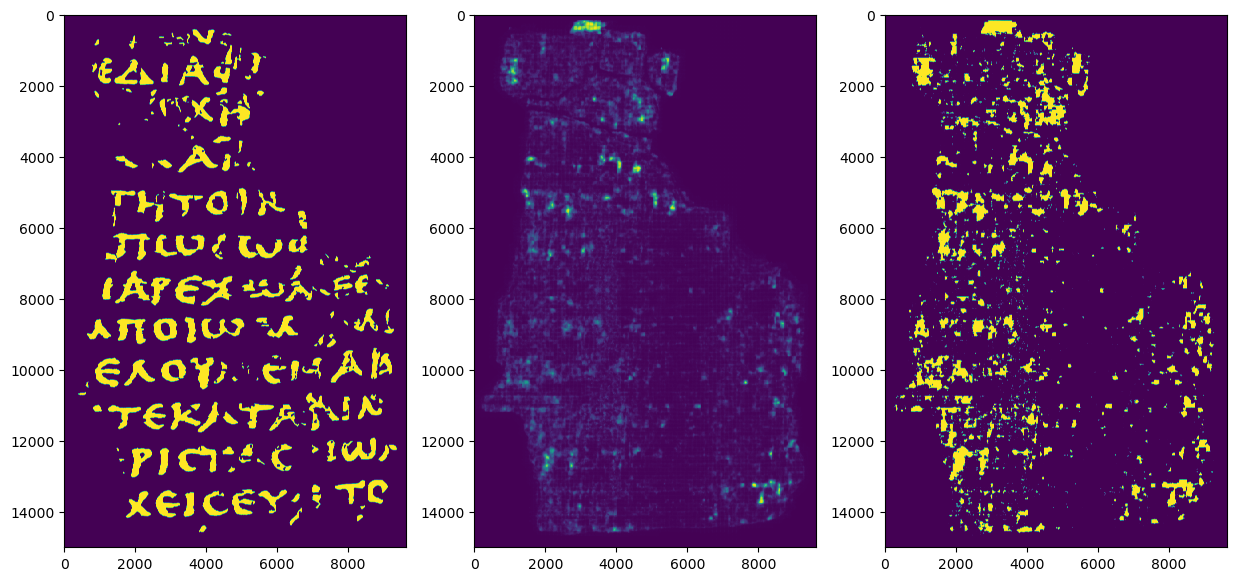

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.15526601e+08, 1.66897270e+07, 5.80960700e+06, 2.59866300e+06,
        1.29464500e+06, 7.21084000e+05, 4.60758000e+05, 3.18387000e+05,
        2.19248000e+05, 1.64845000e+05, 1.31559000e+05, 1.07368000e+05,
        8.81480000e+04, 8.77830000e+04, 8.33560000e+04, 6.58370000e+04,
        6.97540000e+04, 5.74020000e+04, 4.10740000e+04, 2.12100000e+04]),
 array([9.03289056e-05, 4.60193347e-02, 9.19483406e-02, 1.37877346e-01,
        1.83806352e-01, 2.29735358e-01, 2.75664364e-01, 3.21593370e-01,
        3.67522376e-01, 4.13451381e-01, 4.59380387e-01, 5.05309393e-01,
        5.51238399e-01, 5.97167405e-01, 6.43096411e-01, 6.89025416e-01,
        7.34954422e-01, 7.80883428e-01, 8.26812434e-01, 8.72741440e-01,
        9.18670446e-01]),
 <BarContainer object of 20 artists>)

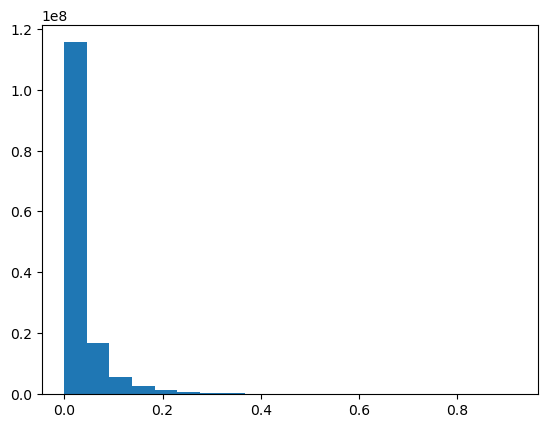

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000